In [36]:
import pandas as pd
import numpy as np
import scipy.stats as stats
from scipy.spatial import distance
from scipy.spatial import cKDTree
import math
import pickle

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style = "whitegrid", palette = 'dark')

from lifelines import KaplanMeierFitter
from lifelines.utils import median_survival_times
from lifelines.statistics import survival_difference_at_fixed_point_in_time_test
from lifelines import CoxPHFitter

from sklearn.model_selection import train_test_split
from sksurv.ensemble import ComponentwiseGradientBoostingSurvivalAnalysis
from sksurv.ensemble import GradientBoostingSurvivalAnalysis
from sklearn.metrics import mean_squared_error

from scipy.spatial import Voronoi, voronoi_plot_2d
from scipy.spatial import ConvexHull, Delaunay
from scipy.spatial.distance import euclidean

import get_data
import tackle_plot

import warnings
warnings.filterwarnings('ignore')
%load_ext autoreload
%autoreload 2

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [37]:
def plot(gameId, playId):
    game = get_data.game(gameId)
    play = get_data.play(gameId, playId)
    tracking = get_data.tracking(gameId, playId).reset_index()
    
    date = game['gameDate'].item()
    tacklers = get_data.tacklers(gameId, playId)
    carrier = play['ballCarrierId'].item()
    offense = play['possessionTeam'].item()
    defense = play['defensiveTeam'].item()
    down = play['down'].item()
    yardstogo = play['yardsToGo'].item()
    ablos = play['absoluteYardlineNumber'].item()    
    
    return tackle_plot.plot(tracking, date, tacklers, carrier, offense, defense, down, yardstogo, ablos) 

In [38]:
progress_df3 = pd.read_csv('../newdata/progress_df3.csv')

## Gradient Boost Models

scikit-survival provided two types of gradient boost models:
- GradientBoostingSurvivalAnalysis: uses regression tree base learner. 
- ComponentwiseGradientBoostingSurvivalAnalysis: uses component-wise least squares as base learner.

Similar to the CPH model, these two gradient boost models use the concordance index (cindex) as the main evaluation method.

In [39]:
model_df = progress_df3[['lst_event', 'progress', 'near_defender_MPD', 'near_dist', 
                         'leverage', 'caught_width', 'SoF', 'has_blocker']]

In [40]:
# Format the y variable to indicate censored data
y = np.array([(event, progress) for event, progress in zip(model_df['lst_event'], model_df['progress'])],
             dtype=[('lst_event', bool), ('progress', float)])

In [41]:
X = model_df[['near_defender_MPD', 'near_dist', 'leverage', 'caught_width', 'SoF', 'has_blocker']]

In [42]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)

### GradientBoostingSurvivalAnalysis model

Find efficient hyperparameters

In [43]:
%%time
scores_tree = {}
gb_tree = GradientBoostingSurvivalAnalysis(learning_rate=1.0, max_depth=1, random_state=0, loss="coxph")
for i in range(1, 31):
    n_estimators = i * 5
    gb_tree.set_params(n_estimators=n_estimators)
    gb_tree.fit(X_train, y_train)
    scores_tree[n_estimators] = gb_tree.score(X_test, y_test)

CPU times: total: 6min 28s
Wall time: 6min 29s


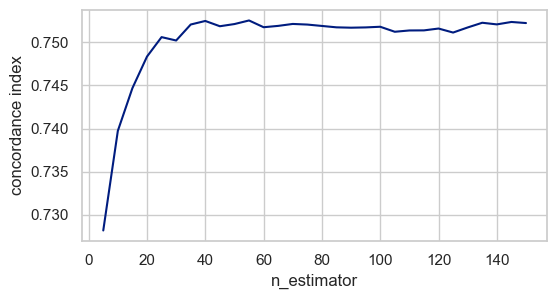

In [44]:
plt.figure(figsize=(6, 3))
plot_x, plot_y = zip(*scores_tree.items())
plt.plot(plot_x, plot_y)
plt.xlabel("n_estimator")
plt.ylabel("concordance index")
plt.show()

In [45]:
# %%time
# cindex_tree = []
# gb_tree = GradientBoostingSurvivalAnalysis(max_depth=1, random_state=0, loss="coxph")

# for learning_rate in [0.1, 0.01, 0.001]:
#     for dropout_rate in [0, 0.1, 0.2]:
#         for n_estimators in range(30, 140, 5):
#             gb_tree.set_params(learning_rate = learning_rate, dropout_rate=dropout_rate, n_estimators = n_estimators)
#             gb_tree.fit(X_train, y_train)            
#             cindex = gb_tree.score(X_test, y_test)
#             cindex_tree.append({'learning_rate': learning_rate, 'dropout_rate':dropout_rate, 
#                                  'n_estimators': n_estimators, 'cindex':cindex})
            
# cindex_tree = pd.DataFrame(cindex_tree)

# max_index = cindex_tree['cindex'].idxmax()

# best_lr = cindex_tree.at[max_index, 'learning_rate']
# best_dr = cindex_tree.at[max_index, 'dropout_rate']
# best_ne = cindex_tree.at[max_index, 'n_estimators']
# best_lr, best_dr, best_ne

In [46]:
best_lr, best_dr, best_ne = 0.1, 0.0, 135
gb_tree = GradientBoostingSurvivalAnalysis(n_estimators=best_ne, learning_rate=best_lr, dropout_rate = best_dr,
                                           max_depth=1, random_state=0, loss="coxph")
gb_tree.fit(X_train, y_train)

GradientBoostingSurvivalAnalysis(max_depth=1, n_estimators=135, random_state=0)

In [47]:
cindex_tree = gb_tree.score(X_test, y_test)
cindex_tree

0.7554767660419073

### Drop features 'leverage' and 'caught_width' then fit the model again

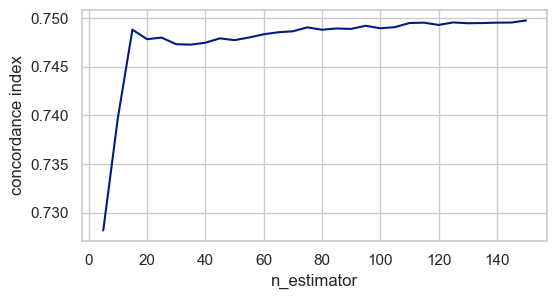

In [48]:
X_1 = model_df[['near_defender_MPD', 'near_dist', 'SoF', 'has_blocker']]
X_1_train, X_1_test, y_1_train, y_1_test = train_test_split(X_1, y, test_size=0.25, random_state=0)

scores_tree_1 = {}
gb_tree_1 = GradientBoostingSurvivalAnalysis(learning_rate=1.0, max_depth=1, random_state=0, loss="coxph")
for i in range(1, 31):
    n_estimators = i * 5
    gb_tree_1.set_params(n_estimators=n_estimators)
    gb_tree_1.fit(X_1_train, y_1_train)
    scores_tree_1[n_estimators] = gb_tree_1.score(X_1_test, y_1_test)
    
plt.figure(figsize=(6, 3))
plot_x, plot_y = zip(*scores_tree_1.items())
plt.plot(plot_x, plot_y)
plt.xlabel("n_estimator")
plt.ylabel("concordance index")
plt.show()

In [49]:
# %%time
# cindex_tree = []
# gb_tree = GradientBoostingSurvivalAnalysis(max_depth=1, random_state=0, loss="coxph")

# for learning_rate in [0.1, 0.01, 0.001]:
#     for dropout_rate in [0, 0.1, 0.2]:
#         for n_estimators in range(80, 160, 5):
#             gb_tree.set_params(learning_rate = learning_rate, dropout_rate=dropout_rate, n_estimators = n_estimators)
#             gb_tree.fit(X1_train, y_train)            
#             cindex = gb_tree.score(X1_test, y_test)
#             cindex_tree.append({'learning_rate': learning_rate, 'dropout_rate':dropout_rate, 
#                                  'n_estimators': n_estimators, 'cindex':cindex})
            
# cindex_tree = pd.DataFrame(cindex_tree)

# max_index = cindex_tree['cindex'].idxmax()

# best_lr = cindex_tree.at[max_index, 'learning_rate']
# best_dr = cindex_tree.at[max_index, 'dropout_rate']
# best_ne = cindex_tree.at[max_index, 'n_estimators']
# best_lr, best_dr, best_ne

In [50]:
best_lr, best_dr, best_ne = 0.1, 0.0, 140
gb_tree_1 = GradientBoostingSurvivalAnalysis(n_estimators=best_ne, learning_rate=best_lr, dropout_rate = best_dr,
                                           max_depth=1, random_state=0, loss="coxph")
gb_tree_1.fit(X_1_train, y_1_train)
cindex_tree = gb_tree_1.score(X_1_test, y_1_test)
cindex_tree

0.7543245830643391

### ComponentwiseGradientBoostingSurvivalAnalysis

Find efficient hyperparameters

In [51]:
%%time
cindex_ls = []

gb_ls = ComponentwiseGradientBoostingSurvivalAnalysis(random_state=0, loss = 'squared')
for learning_rate in [0.1, 0.01, 0.001]:
    for dropout_rate in [0, 0.1, 0.2, 0.3]:
        for n_estimators in range(15, 150, 5):
            gb_ls.set_params(learning_rate = learning_rate, dropout_rate=dropout_rate, n_estimators = n_estimators)
            gb_ls.fit(X_train, y_train)            
            cindex = gb_ls.score(X_test, y_test)
            cindex_ls.append({'learning_rate': learning_rate, 'dropout_rate':dropout_rate, 
                              'n_estimators': n_estimators, 'cindex':cindex})
cindex_ls = pd.DataFrame(cindex_ls)
max_index = cindex_ls['cindex'].idxmax()

best_lr = cindex_ls.at[max_index, 'learning_rate']
best_dr = cindex_ls.at[max_index, 'dropout_rate']
best_ne = cindex_ls.at[max_index, 'n_estimators']
best_lr, best_dr, best_ne

CPU times: total: 25.2 s
Wall time: 25.2 s


(0.1, 0.0, 70)

In [52]:
gb_ls = ComponentwiseGradientBoostingSurvivalAnalysis(n_estimators=best_ne, learning_rate=best_lr, 
                                                      dropout_rate = best_dr, random_state=0, loss="squared")
gb_ls.fit(X_train, y_train)

ComponentwiseGradientBoostingSurvivalAnalysis(dropout_rate=0.0, loss='squared',
                                              n_estimators=70, random_state=0)

In [53]:
cindex_ls = gb_ls.score(X_test, y_test)
cindex_ls

0.7435282258850181

The cindex of this model is lower than both cph model and tree-based GB model. However, it provides suggestions on feature selection as below:

In [54]:
coef = pd.Series(gb_ls.coef_, ["Intercept"] + X.columns.tolist())

print("Number of non-zero coefficients:", (coef != 0).sum())
coef_nz = coef[coef != 0]
coef_order = coef_nz.abs().sort_values(ascending=False).index
coef_nz.loc[coef_order]

Number of non-zero coefficients: 6


has_blocker          0.465417
near_dist            0.182473
near_defender_MPD    0.106285
leverage            -0.064963
Intercept           -0.030349
SoF                  0.003200
dtype: float64

The model suggests drop 'caught_with' like previous models. The low coefficient of SoF implies its non-linear impact on the target variable.

## Check predicted probability distribution and rsme 

- use tree-based model to predict probability

In [70]:
def plot_prob(df_predict):
    
    '''
    Trains a Cox Proportional Hazards model on specified dataset, evaluates its performance on a test set, 
    and visualizes the results.

    Args:
    - model_df (DataFrame): The input dataframe for modeling.
    - robust (bool, optional): If True, a robust fitting approach is used. Default is False.
    '''    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5), gridspec_kw={'width_ratios': [1, 5]})

    # Histogram of Predicted Probabilities
    n, bins, patches = ax1.hist(df_predict['Predicted_Probability'], bins=6, alpha=0.7)
    ax1.set_title('Histogram of Predicted Probabilities')
    ax1.set_xlabel('Predicted Probability')
    ax1.set_ylabel('Frequency')

    for i in range(len(patches)):
        ax1.text(patches[i].xy[0] + patches[i].get_width() / 2, patches[i].get_height(), 
                 f'{n[i]/len(df_predict):.2f}', ha='center', va='bottom')
        
    # Scatter Plot of Predicted Probabilities vs Progress
    sns.scatterplot(data=df_predict, x='progress', y='Predicted_Probability', s=5, ax=ax2)
    ax2.set_title('GB Model - Scatter Plot of Predicted Probabilities vs Progress')
    ax2.set_xlabel('Progress')
    ax2.set_ylabel('Predicted Probability')

    plt.tight_layout()
    plt.show()

In [56]:
X_test_reset = X_test.reset_index(drop = True)

In [57]:
predict_df = pd.DataFrame()
predict_df['progress'] = [y[1] for y in y_test]
predict_df = pd.merge(predict_df, X_test_reset, left_index = True, right_index = True)

In [58]:
predict_df['sf'] = gb_tree.predict_survival_function(X_test_reset)

In [59]:
predict_probs = []
for index, row in predict_df.iterrows():
    sf = row['sf']
    survival_function = pd.DataFrame({'probability': sf.y}, index=sf.x)
    progress = math.floor(row['progress']*10)/10
    closest_idx = abs(survival_function.index - progress).argmin()
    progress = survival_function.index[closest_idx]
    probability = survival_function.loc[progress, 'probability']
    predict_probs.append(probability)    

In [71]:
predict_df['Predicted_Probability'] = predict_probs
predict_df['Predicted_Probability'] = predict_df['Predicted_Probability'].round(2)

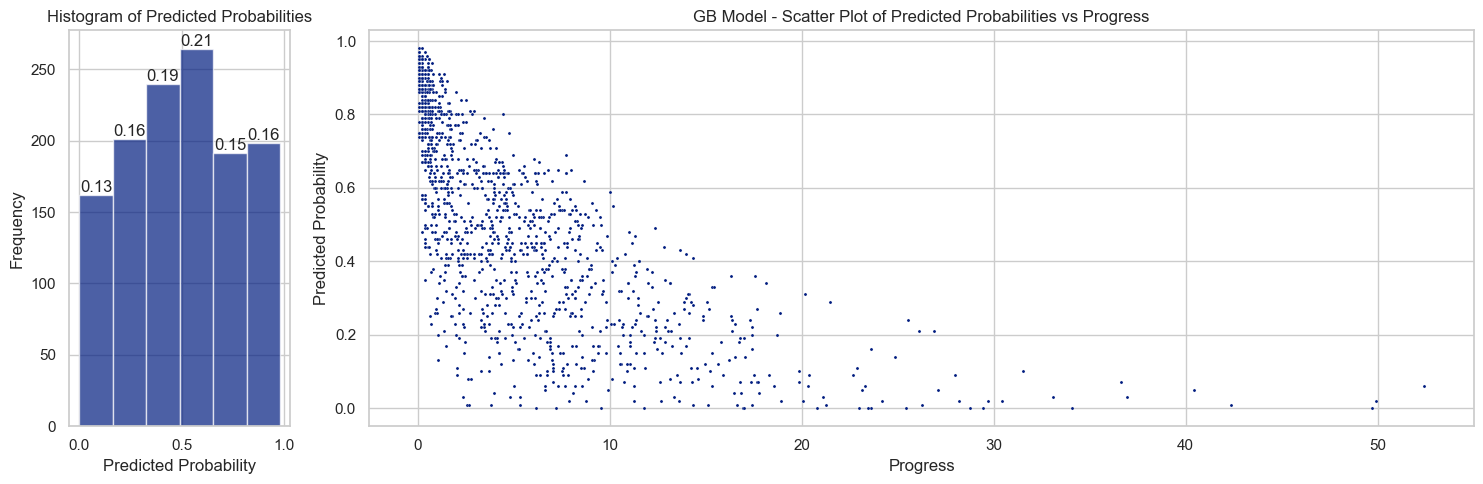

In [72]:
plot_prob(predict_df)

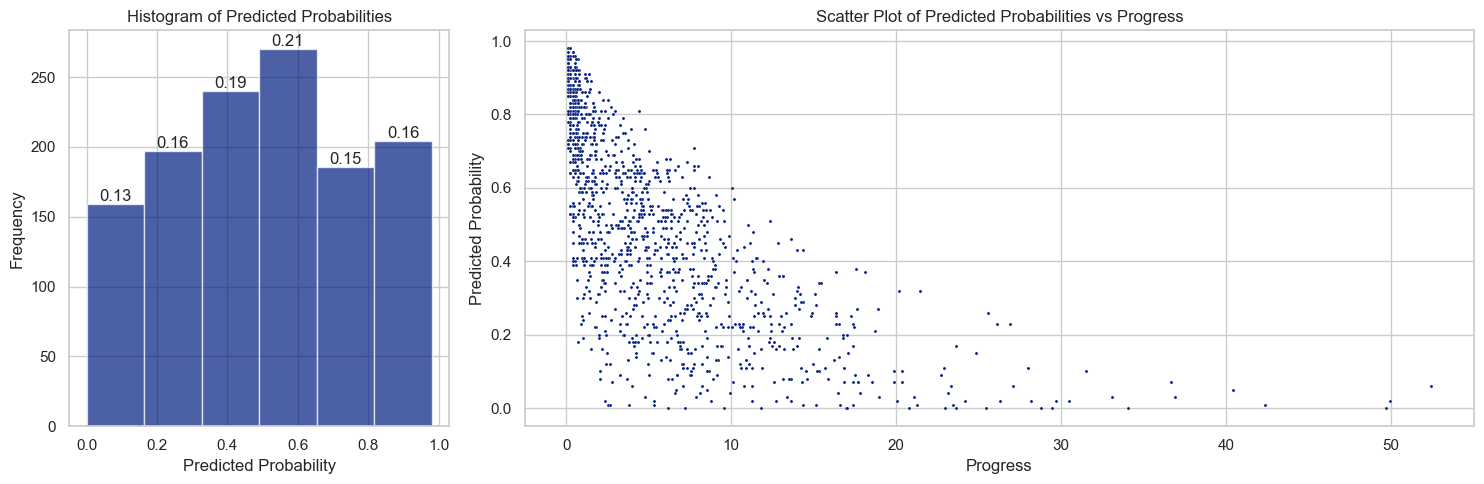

In [62]:
X_1_test_reset = X_1_test.reset_index(drop = True)
predict_df_1 = pd.DataFrame()
predict_df_1['progress'] = [y[1] for y in y_1_test]
predict_df_1 = pd.merge(predict_df_1, X_1_test_reset, left_index = True, right_index = True)
predict_df_1['sf'] = gb_tree_1.predict_survival_function(X_1_test_reset)

predict_probs_1 = []
for index, row in predict_df_1.iterrows():
    sf = row['sf']
    survival_function = pd.DataFrame({'probability': sf.y}, index=sf.x)
    progress = math.floor(row['progress']*10)/10
    closest_idx = abs(survival_function.index - progress).argmin()
    progress = survival_function.index[closest_idx]
    probability = survival_function.loc[progress, 'probability']
    predict_probs_1.append(probability)    

predict_df_1['Predicted_Probability'] = predict_probs_1
predict_df_1['Predicted_Probability'] = predict_df_1['Predicted_Probability'].round(2)
plot_prob(predict_df_1)

The CPH model and the Gradient Boost model showed different prediction patterns. The CPH model tends to set a limit on the lower end of probability when predicting small number durations. The Gradient Boost model tends to set a limit on the higher end of probability when predicting large number durations. Considering the significance of meaningful prediction on small number durations, I chose the Gradient Boost model for the following model application. In addition, as not enough evidence shows features 'leverage' and 'caught_width' are significant, I chose the Gradient Boost model with these two being dropped as the final model.

- Use component-wise least squares model to predict duration

In [63]:
predict_df['ex_progress'] = gb_ls.predict(X_test_reset)
predict_df['error'] = predict_df['ex_progress'] - predict_df['progress']
rmse = np.sqrt(mean_squared_error(predict_df['progress'], predict_df['ex_progress']))
rmse

6.553107152470817

<Axes: xlabel='progress', ylabel='error'>

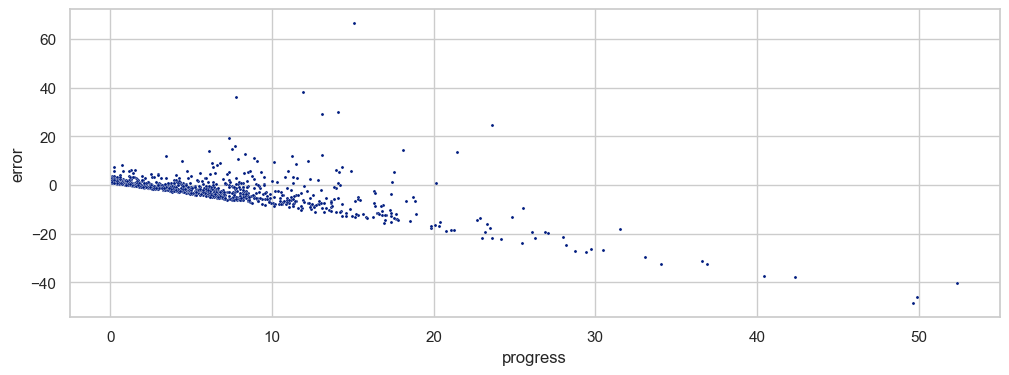

In [64]:
plt.figure(figsize=(12, 4))
sns.scatterplot(data = predict_df, x = 'progress', y = 'error', s = 5)

In [65]:
# with open('../saved_models/gb_tree.pkl', 'wb') as file:
#     pickle.dump(gb_tree, file)

In [66]:
# with open('../saved_models/gb_tree_1.pkl', 'wb') as file:
#     pickle.dump(gb_tree_1, file)

In [67]:
# with open('../saved_models/gb_ls.pkl', 'wb') as file:
#     pickle.dump(gb_ls, file)